In [176]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [244]:
cmap = {'Vehicle': '#000000',
 'ABT-263': '#a9a9a9',
 'Venetoclax': '#a9a9a9',
 'Protac bcl2': '#f08080',
 'Protac bclxl': '#f08080'}

# OFT

In [245]:
oft = pd.read_excel('../data/bh_format.xlsx', sheet_name='oft')

In [246]:
oft_long = oft.melt(id_vars=['id','Drug','Sex','aka'], value_vars=['Distance Total cm', 'Periphery Duration %', 'Center Duration %'])
oft_long.aka = oft_long.aka.astype('category').cat.reorder_categories(['Vehicle','Drug1','Drug2','Drug3'])
oft_long.Drug = oft_long.Drug.astype('category').cat.reorder_categories(['Vehicle','Venetoclax','Protac bcl2','Protac bclxl'])

In [247]:
oft_dis = oft_long[oft_long.variable.str.startswith('Distance')].reset_index(drop=True)
oft_per = oft_long[~oft_long.variable.str.startswith('Distance')].reset_index(drop=True)
oft_per.variable = oft_per.variable.str.strip(' %')
oft_per.variable = oft_per.variable.astype('category').cat.reorder_categories(['Center Duration','Periphery Duration'])

In [291]:
oft_long.groupby(['id','Drug','variable']).value.mean().unstack()

variable             Center Duration %  Distance Total cm  \
id     Drug                                                 
752447 Vehicle                     NaN                NaN   
       Venetoclax              13.3731            6934.59   
       Protac bcl2                 NaN                NaN   
       Protac bclxl                NaN                NaN   
752448 Vehicle                 26.3721            6495.01   
...                                ...                ...   
769741 Protac bclxl                NaN                NaN   
769742 Vehicle                     NaN                NaN   
       Venetoclax                  NaN                NaN   
       Protac bcl2                 NaN                NaN   
       Protac bclxl            14.4397            4696.56   

variable             Periphery Duration %  
id     Drug                                
752447 Vehicle                        NaN  
       Venetoclax                 86.6269  
       Protac bcl2                    NaN  
       Protac bclxl                   NaN  
752448 Vehicle                    73.6279  
...                                   ...  
769741 Protac bclxl                   NaN  
769742 Vehicle                        NaN  
       Venetoclax                     NaN  
       Protac bcl2                    NaN  
       Protac bclxl               85.5603  

[96 rows x 3 columns]

In [248]:
from statsmodels.stats.multitest import multipletests
drug = []
ttest=[]
for d in oft_dis.Drug.cat.categories[1:]:
    drug.append(d)
    st, p = stats.ttest_ind(oft_dis[(oft_dis.Drug == d)].value,
                            oft_dis[(oft_dis.Drug == 'Vehicle')].value)
    ttest.append(p)
ttest = multipletests(ttest, alpha=0.05, method='bonferroni')[1]
ttest

array([0.17865232, 0.24381559, 0.1912559 ])

In [249]:
drug

['Venetoclax', 'Protac bcl2', 'Protac bclxl']

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_4822/734409489.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Veh','V','P Bcl-2','P Bcl-xL'], rotation=45)


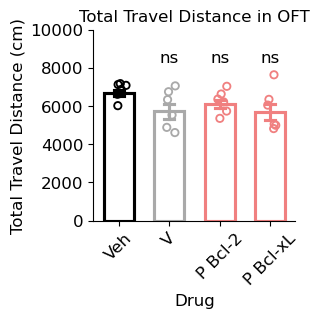

In [250]:
fig, ax = plt.subplots(figsize=(2.75,2.5))
fig.tight_layout()
sns.barplot(data=oft_dis, x='Drug', y='value', hue='Drug',
            fill=False, errorbar=('ci', 68),
            capsize=0.2, ax=ax, width=0.6, palette=cmap)
sns.stripplot(data=oft_dis, x='Drug', y='value', hue='Drug', palette=cmap, zorder=1, marker="$\circ$", edgecolor="face", s=10)
for i in range(len(drug)):
    ax.text(i+1, 8500, '*' if ttest[i] < 0.05 else 'ns', ha='center', va='center', fontsize=12)
ax.set_ylabel('Total Travel Distance (cm)', fontsize=12)
ax.set_xlabel('Drug', fontsize=12)
ax.tick_params(labelsize=12)
ax.set_xticklabels(['Veh','V','P Bcl-2','P Bcl-xL'], rotation=45)
ax.set_ylim(0, 10000)
ax.set_title('Total Travel Distance in OFT', fontsize=12)
for i in ['top', 'right']:
    ax.spines[i].set_visible(False)
fig.savefig('/Users/pax/Library/CloudStorage/OneDrive-KarolinskaInstitutet/BHDrug_plots/bh_oft_total_dis.pdf', bbox_inches='tight', dpi=300)

In [252]:
from statsmodels.stats.multitest import multipletests
ttest={}
for loc in oft_per.variable.cat.categories:
    ttest[loc] = []
    for d in oft_per.Drug.cat.categories[1:]:
        st, p = stats.ttest_ind(oft_per[(oft_per.variable == loc) & (oft_per.Drug == d)].value,
                                oft_per[(oft_per.variable == loc) & (oft_per.Drug == 'Vehicle')].value)
        ttest[loc].append(p)
    ttest[loc] = multipletests(ttest[loc], alpha=0.05, method='bonferroni')[1]
ttest

{'Center Duration': array([0.29172835, 1.        , 1.        ]),
 'Periphery Duration': array([0.29172889, 1.        , 1.        ])}

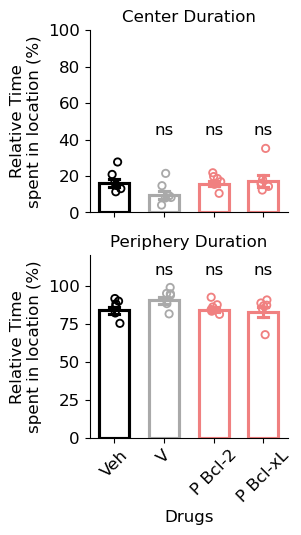

In [253]:
g = sns.catplot(
    oft_per, kind="bar", fill=False, errorbar=('ci', 68), capsize=0.2,
    x="Drug" ,y="value", hue="Drug", row="variable", width=0.6,
    height=2.5, aspect=1.2, legend=False, sharey=False, palette=cmap)
g.map_dataframe(sns.stripplot, x="Drug", y="value", hue='Drug', zorder=1, dodge=False, palette=cmap, marker="$\circ$", edgecolor="face", s=10)
g.tight_layout()
g.tick_params(labelsize=12)
g.set_ylabels('Relative Time\nspent in location (%)', fontsize=12)
g.set_xlabels('Drugs', fontsize=12)
g.set_xticklabels(['Veh','V','P Bcl-2','P Bcl-xL'], rotation=45)
g.set_titles('{row_name}', size=12)
for i, ax in enumerate(g.axes.flat):
    ax.set_ylim(0, 120 if i != 0 else 100)
    for j in range(len(drug)):
        ax.text(j+1, 110 if i != 0 else 45, '*' if ttest[oft_per.variable.cat.categories[i]][j] < 0.05 else 'ns', ha='center', va='center', fontsize=12)
g.axes[1][0].yaxis.get_major_ticks()[-1].label1.set_visible(False)
g.axes[1][0].yaxis.get_major_ticks()[-1].tick1line.set_visible(False)
g.savefig('/Users/pax/Library/CloudStorage/OneDrive-KarolinskaInstitutet/BHDrug_plots/bh_oft_percent_loc_new.pdf', bbox_inches='tight', dpi=300)

# EPM

In [412]:
epm = pd.read_excel('../data/bh_format.xlsx', sheet_name='epm')

In [413]:
epm_long = epm.melt(id_vars=['id','Drug','Sex','aka'], value_vars=['Distance Total cm', 'Center Duration %','Open Arm Duration %','Closed Arm Duration %'])
epm_long.aka = epm_long.aka.astype('category').cat.reorder_categories(['Vehicle','Drug1','Drug2','Drug3'])
epm_long.Drug = epm_long.Drug.astype('category').cat.reorder_categories(['Vehicle','Venetoclax','Protac bcl2','Protac bclxl'])

In [414]:
epm_dis = epm_long[epm_long.variable.str.startswith('Distance')].reset_index(drop=True)
epm_per = epm_long[~epm_long.variable.str.startswith('Distance')].reset_index(drop=True)
epm_per.variable = epm_per.variable.str.strip(' %')
epm_per.variable = epm_per.variable.astype('category').cat.reorder_categories(['Center Duration','Open Arm Duration','Closed Arm Duration'])

In [415]:
from statsmodels.stats.multitest import multipletests
drug = []
ttest=[]
for d in epm_dis.Drug.cat.categories[1:]:
    drug.append(d)
    st, p = stats.ttest_ind(epm_dis[(epm_dis.Drug == d)].value,
                            epm_dis[(epm_dis.Drug == 'Vehicle')].value)
    ttest.append(p)
ttest = multipletests(ttest, alpha=0.05, method='bonferroni')[1]
ttest

array([1.        , 0.98330422, 1.        ])

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_4822/2571613469.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Veh','V','P Bcl-2','P Bcl-xL'], rotation=45)


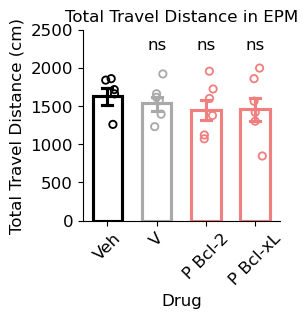

In [418]:
fig, ax = plt.subplots(figsize=(2.7,2.5))
fig.tight_layout()
sns.barplot(data=epm_dis, x='Drug', y='value', hue='Drug',
            fill=False, errorbar=('ci', 68), capsize=0.2,
            ax=ax, width=0.6, palette=cmap)
sns.stripplot(data=epm_dis, x='Drug', y='value', hue='Drug', palette=cmap,
              zorder=0, marker="$\circ$", edgecolor="face", s=10, dodge=False)
for i in range(len(drug)):
    ax.text(i+1, 2300, '*' if ttest[i] < 0.05 else 'ns', ha='center', va='center', fontsize=12)
ax.set_ylabel('Total Travel Distance (cm)', fontsize=12)
ax.set_xlabel('Drug', fontsize=12)
ax.tick_params(labelsize=12)
ax.set_xticklabels(['Veh','V','P Bcl-2','P Bcl-xL'], rotation=45)
ax.set_ylim(0, 2500)
ax.set_title('Total Travel Distance in EPM', fontsize=12)
for i in ['top', 'right']:
    ax.spines[i].set_visible(False)
fig.savefig('/Users/pax/Library/CloudStorage/OneDrive-KarolinskaInstitutet/BHDrug_plots/bh_epm_total_dis.pdf', bbox_inches='tight', dpi=300)

In [261]:
from statsmodels.stats.multitest import multipletests
ttest={}
for loc in epm_per.variable.cat.categories:
    ttest[loc] = []
    for d in epm_per.Drug.cat.categories[1:]:
        st, p = stats.ttest_ind(epm_per[(epm_per.variable == loc) & (epm_per.Drug == d)].value,
                                epm_per[(epm_per.variable == loc) & (epm_per.Drug == 'Vehicle')].value)
        ttest[loc].append(p)
    ttest[loc] = multipletests(ttest[loc], alpha=0.05, method='bonferroni')[1]
ttest

{'Center Duration': array([1., 1., 1.]),
 'Open Arm Duration': array([1.        , 0.11312322, 0.39912751]),
 'Closed Arm Duration': array([1.        , 0.30306873, 1.        ])}

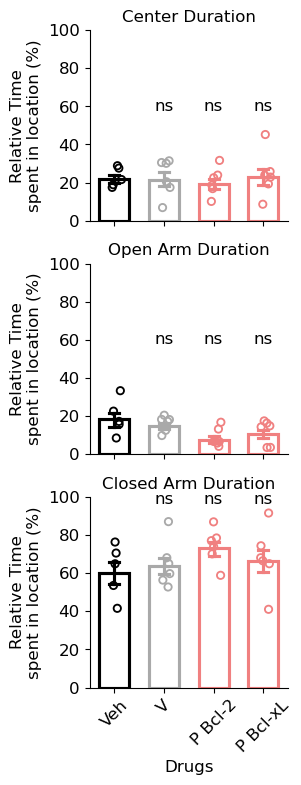

In [262]:
g = sns.catplot(
    epm_per, kind="bar", fill=False, errorbar=('ci', 68), capsize=0.2,
    x="Drug" ,y="value", hue="Drug", row="variable", palette=cmap, width=0.6,
    height=2.5, aspect=1.2, legend=False, facet_kws=dict(ylim=(0,100)))
g.map_dataframe(sns.stripplot, x="Drug", y="value", hue='Drug', palette=cmap,
                zorder=1, dodge=False, marker="$\circ$", edgecolor="face", s=10)
g.tight_layout()
g.tick_params(labelsize=12)
g.set_xticklabels(['Veh','V','P Bcl-2','P Bcl-xL'], rotation=45)
g.set_ylabels('Relative Time\nspent in location (%)', fontsize=12)
g.set_xlabels('Drugs', fontsize=12)
g.set_titles('{row_name}', size=12)
for i, ax in enumerate(g.axes.flat):
    for j in range(len(drug)):
        ax.text(j+1, 60 if i != 2 else 99, '*' if ttest[epm_per.variable.cat.categories[i]][j] < 0.05 else 'ns', ha='center', va='center', fontsize=12)
g.savefig('/Users/pax/Library/CloudStorage/OneDrive-KarolinskaInstitutet/BHDrug_plots/bh_epm_percent_loc.pdf', bbox_inches='tight', dpi=300)

# Rod

In [419]:
rod = pd.read_excel('../data/bh_format.xlsx', sheet_name='rod')

In [420]:
rod_time = rod.melt(id_vars=['id','Drug','Sex','aka'], value_vars=rod.columns[rod.columns.str.contains('(s)')][2:]) # only used the last 3 trials
rod_rpm = rod.melt(id_vars=['id','Drug','Sex','aka'], value_vars=rod.columns[rod.columns.str.contains('(rpm)')][2:])

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_4822/3805887013.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  rod_time = rod.melt(id_vars=['id','Drug','Sex','aka'], value_vars=rod.columns[rod.columns.str.contains('(s)')][2:]) # only used the last 3 trials
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_4822/3805887013.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  rod_rpm = rod.melt(id_vars=['id','Drug','Sex','aka'], value_vars=rod.columns[rod.columns.str.contains('(rpm)')][2:])


In [421]:
rod_time['Measure'] = 'Time'
rod_rpm['Measure'] = 'RPM'
rod_long = pd.concat([rod_time, rod_rpm], axis=0, ignore_index=True).reset_index(drop=True)

In [422]:
rod_long.Drug = rod_long.Drug.astype('category').cat.reorder_categories(['Vehicle','Venetoclax','Protac bcl2','Protac bclxl'])
rod_long.Measure = rod_long.Measure.astype('category').cat.reorder_categories(['Time','RPM'])

In [423]:
# from statsmodels.stats.multitest import multipletests
# ttest={}
# for m in rod_long.Measure.cat.categories:
#     ttest[m] = []
#     for d in rod_long.Drug.cat.categories[1:]:
#         st, p = stats.ttest_ind(rod_long[(rod_long.Measure == m) & (rod_long.Drug == d)].value,
#                                 rod_long[(rod_long.Measure == m) & (rod_long.Drug == 'Vehicle')].value)
#         ttest[m].append(p)
#     ttest[m] = multipletests(ttest[m], alpha=0.05, method='bonferroni')[1]
# ttest

In [424]:
rod_long_mean = rod_long.groupby(['id','Drug','Measure']).value.mean().dropna().unstack().reset_index(level=1).reset_index().melt(id_vars=['id','Drug'], value_vars=['Time','RPM'], var_name='Measure')

In [425]:
rod_long_mean.Measure = rod_long_mean.Measure.astype('category').cat.reorder_categories(['Time','RPM'])
rod_long_mean.Drug = rod_long_mean.Drug.astype('category').cat.reorder_categories(['Vehicle','Venetoclax','Protac bcl2','Protac bclxl'])

In [426]:
from statsmodels.stats.multitest import multipletests
ttest={}
for m in rod_long_mean.Measure.cat.categories:
    ttest[m] = []
    for d in rod_long_mean.Drug.cat.categories[1:]:
        st, p = stats.ttest_ind(rod_long_mean[(rod_long_mean.Measure == m) & (rod_long_mean.Drug == d)].value,
                                rod_long_mean[(rod_long_mean.Measure == m) & (rod_long_mean.Drug == 'Vehicle')].value)
        ttest[m].append(p)
    ttest[m] = multipletests(ttest[m], alpha=0.05, method='bonferroni')[1]
ttest

{'Time': array([0.62972582, 1.        , 0.47233648]),
 'RPM': array([0.7489657 , 0.66230648, 0.50360062])}

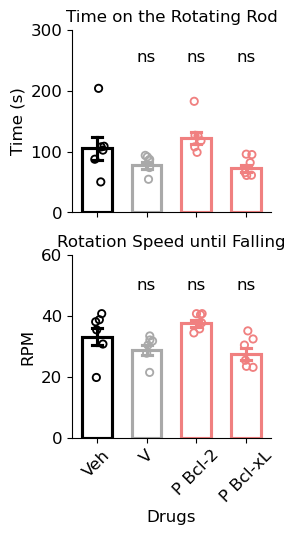

In [429]:
g = sns.catplot(
    rod_long_mean, kind="bar", fill=False, errorbar=('ci', 68), capsize=0.2,
    x="Drug" ,y="value", hue="Drug", row="Measure", palette=cmap, width=0.6,
    height=2.5, aspect=1.2, legend=False, sharey=False)
g.map_dataframe(sns.stripplot, x="Drug", y="value", hue='Drug', palette=cmap,
                zorder=1, dodge=False, marker="$\circ$", edgecolor="face", s=10)
g.tight_layout()
g.tick_params(labelsize=12)
g.set_xticklabels(['Veh','V','P Bcl-2','P Bcl-xL'], rotation=45)
g.set_xlabels('Drugs', fontsize=12)
g.set_titles('{row_name}', size=12)
for i, ax in enumerate(g.axes.flat):
    if i == 0:
        ax.set_ylim(0, 300)
        ax.set_ylabel('Time (s)', fontsize=12)
        ax.set_title('Time on the Rotating Rod', fontsize=12)
    else:
        ax.set_ylim(0, 60)
        ax.set_ylabel('RPM', fontsize=12)
        ax.set_title('Rotation Speed until Falling', fontsize=12)
    for j in range(len(drug)):
        ax.text(j+1, 255 if i == 0 else 50, '*' if ttest[rod_long_mean.Measure.cat.categories[i]][j] < 0.05 else 'ns', ha='center', va='center', fontsize=12)
g.savefig('/Users/pax/Library/CloudStorage/OneDrive-KarolinskaInstitutet/BHDrug_plots/bh_rod.pdf', bbox_inches='tight', dpi=300)

# Beam

In [373]:
beam = pd.read_excel('../data/bh_format.xlsx', sheet_name='beam')

In [374]:
beam_time = beam.melt(id_vars=['id','Drug','Sex','aka','Beam'], value_vars=beam.columns[beam.columns.str.contains('(s)')])
beam_score = beam.melt(id_vars=['id','Drug','Sex','aka','Beam'], value_vars=beam.columns[beam.columns.str.contains('Score')])

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_4822/4103444618.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  beam_time = beam.melt(id_vars=['id','Drug','Sex','aka','Beam'], value_vars=beam.columns[beam.columns.str.contains('(s)')])


In [375]:
beam_time['Measure'] = 'Time'
beam_score['Measure'] = 'Score'
beam_long = pd.concat([beam_time, beam_score], axis=0, ignore_index=True).reset_index(drop=True)

In [377]:
beam_long.Drug = beam_long.Drug.astype('category').cat.reorder_categories(['Vehicle','Venetoclax','Protac bcl2','Protac bclxl'])
beam_long.Measure = beam_long.Measure.astype('category').cat.reorder_categories(['Time','Score'])
beam_long.Beam = beam_long.Beam.astype('category').cat.reorder_categories(['Small','Medium','Large','Largest'])
beam_long.Beam = beam_long.Beam.astype('category').cat.rename_categories({'Largest':'X-Large'})

In [387]:
beam_long_mean = beam_long.groupby(['id','Drug','Measure','Beam']).value.mean().dropna().unstack()\
    .reset_index(level=[1,2]).reset_index()\
        .melt(id_vars=['id','Drug','Measure'], value_vars=beam_long.Beam.cat.categories)

In [389]:
beam_long_mean.Measure = beam_long_mean.Measure.astype('category').cat.reorder_categories(['Time','Score'])
beam_long_mean.Drug = beam_long_mean.Drug.astype('category').cat.reorder_categories(['Vehicle','Venetoclax','Protac bcl2','Protac bclxl'])
beam_long_mean.Beam = beam_long_mean.Beam.astype('category').cat.reorder_categories(['Small','Medium','Large','X-Large'])

In [390]:
from statsmodels.stats.multitest import multipletests
ttest={}
for m in beam_long_mean.Measure.cat.categories:
    ttest[m] = {}
    for b in beam_long_mean.Beam.cat.categories:
        ttest[m][b] = []
        for d in beam_long_mean.Drug.cat.categories[:-1]:
            st, p = stats.ttest_ind(beam_long_mean[(beam_long_mean.Measure == m) & (beam_long_mean.Beam == b) & (beam_long_mean.Drug == d)].value,
                                    beam_long_mean[(beam_long_mean.Measure == m) & (beam_long_mean.Beam == b) & (beam_long_mean.Drug == 'Vehicle')].value)
            ttest[m][b].append(p)
        ttest[m][b] = multipletests(ttest[m][b], alpha=0.05, method='bonferroni')[1]
ttest

{'Time': {'Small': array([1., 1., 1.]),
  'Medium': array([1., 1., 1.]),
  'Large': array([1., 1., 1.]),
  'X-Large': array([1., 1., 1.])},
 'Score': {'Small': array([1.       , 1.       , 0.8578829]),
  'Medium': array([1., 1., 1.]),
  'Large': array([1., 1., 1.]),
  'X-Large': array([1., 1., 1.])}}

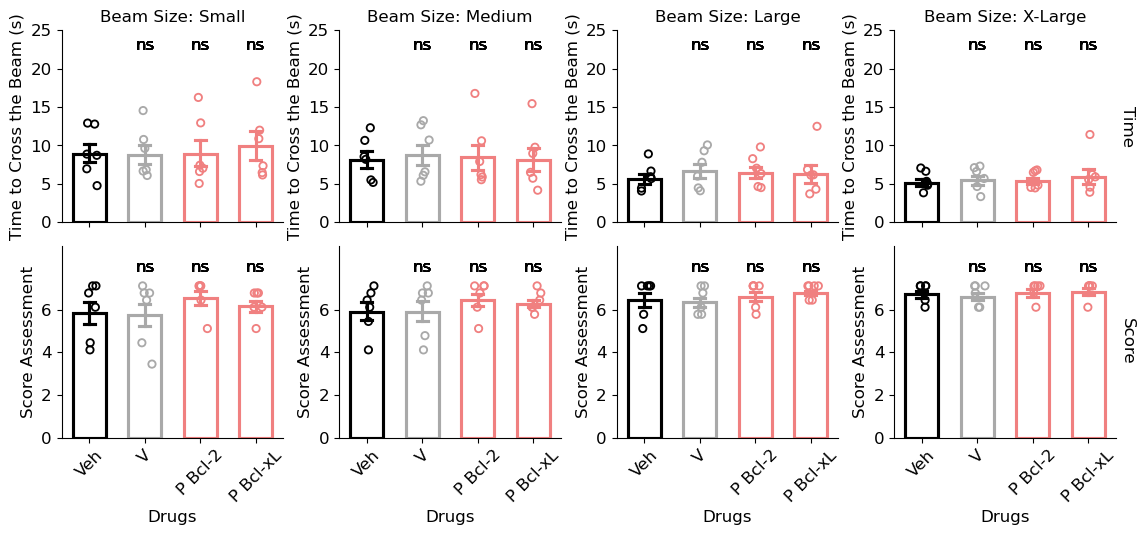

In [391]:
g = sns.catplot(
    beam_long_mean, kind="bar", fill=False, errorbar=('ci', 68), capsize=0.2,
    x="Drug" ,y="value", hue='Drug', row="Measure", col="Beam", palette=cmap, width=0.6,
    height=2.5, aspect=1.2, margin_titles=True, sharey=False)
g.map_dataframe(sns.stripplot, x="Drug", y="value", hue='Drug', palette=cmap,
                zorder=1, size=10, dodge=False, marker="$\circ$", edgecolor="face")
# g.tight_layout()
g.legend.set_visible(False)
g.tick_params(labelsize=12)
g.set_xticklabels(['Veh','V','P Bcl-2','P Bcl-xL'], rotation=45)
g.set_xlabels('Drugs', fontsize=12)
g.set_titles(row_template='{row_name}', col_template='Beam Size: {col_name}', size=12)
for i, ax in enumerate(g.axes.flat):
    if i in list(range(4)):
        ax.set_ylim(0, 25)
        ax.set_ylabel('Time to Cross the Beam (s)', fontsize=12)
    else:
        ax.set_ylim(0, 9)
        ax.set_ylabel('Score Assessment', fontsize=12)
        for t in [-1,-2]:
            ax.yaxis.get_major_ticks()[t].label1.set_visible(False)
            ax.yaxis.get_major_ticks()[t].tick1line.set_visible(False)
    for m in beam_long_mean.Measure.cat.categories:
        for b in beam_long_mean.Beam.cat.categories:
            for j in range(len(drug)):
                ax.text(j+1, 23 if i in list(range(4)) else 8,
                        '*' if ttest[m][b][j] < 0.05 else 'ns',
                        ha='center', va='center', fontsize=12)
g.savefig('/Users/pax/Library/CloudStorage/OneDrive-KarolinskaInstitutet/BHDrug_plots/bh_beam.pdf', bbox_inches='tight', dpi=300)